In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pydataset import data
from datetime import date
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
from env import get_db_url, user, password, host
import acquire
import prepare

In [2]:
# Using titanic data:
# 1. What is your baseline prediction? What is your baseline accuracy? 

In [3]:
titanic = acquire.get_titanic_data()

Using cached csv


In [4]:
titanic = prepare.prep_titanic(titanic)

In [5]:
titanic.head()

,survived,pclass,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0,3,1,0,7.2500,0,1,0,1
1,1,1,1,0,71.2833,0,0,0,0
2,1,3,0,0,7.9250,1,0,0,1
3,1,1,1,0,53.1000,0,0,0,1
4,0,3,0,0,8.0500,1,1,0,1


In [6]:
titanic.survived.value_counts()

0    549
1    342
Name: survived, dtype: int64

In [7]:
# Our target value is 'survived' and the baseline is 0 (did not survive)

In [8]:
titanic['baseline'] = 0

In [9]:
sklearn.metrics.accuracy_score(titanic.survived, titanic.baseline)

0.6161616161616161

In [10]:
# 2. Fit the decision tree classifier to training sample and transform
# Create train, validate, test split of data

In [11]:
def train_validate_test_split(df, target, seed=123):
    '''
    - Takes in df, name of target variable, and integer for setting a seed
    - Splits the data into train, validate, and test
    - Test is 20% of original dataset, validate is .3 * .8 = 24%, train is .7 * .8 = 56% of original dataset
    - Function returns train, validate, test df
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state = seed, stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=.3, random_state=seed, stratify=train_validate[target])
    return train, validate, test

In [12]:
t_train, t_val, t_test = train_validate_test_split(titanic, 'survived')

In [13]:
t_train.shape, t_val.shape, t_test.shape

((498, 10), (214, 10), (179, 10))

In [14]:
x_train = t_train.drop(columns='survived')
y_train = t_train.survived

x_validate = t_val.drop(columns=['survived'])
y_validate = t_val.survived

x_test = t_test.drop(columns='survived')
y_test = t_test.survived

In [15]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [16]:
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [17]:
clf = clf.fit(x_train, y_train)

[Text(362.7, 332.955, 'sex_male <= 0.5\ngini = 0.473\nsamples = 498\nvalue = [307, 191]\nclass = not survived'),
 Text(181.35, 237.825, 'pclass <= 2.5\ngini = 0.365\nsamples = 175\nvalue = [42, 133]\nclass = survived'),
 Text(90.675, 142.695, 'fare <= 28.856\ngini = 0.081\nsamples = 94\nvalue = [4, 90]\nclass = survived'),
 Text(45.3375, 47.565, 'gini = 0.133\nsamples = 42\nvalue = [3, 39]\nclass = survived'),
 Text(136.0125, 47.565, 'gini = 0.038\nsamples = 52\nvalue = [1, 51]\nclass = survived'),
 Text(272.025, 142.695, 'fare <= 23.912\ngini = 0.498\nsamples = 81\nvalue = [38, 43]\nclass = survived'),
 Text(226.6875, 47.565, 'gini = 0.476\nsamples = 69\nvalue = [27, 42]\nclass = survived'),
 Text(317.3625, 47.565, 'gini = 0.153\nsamples = 12\nvalue = [11, 1]\nclass = not survived'),
 Text(544.05, 237.825, 'fare <= 18.275\ngini = 0.295\nsamples = 323\nvalue = [265, 58]\nclass = not survived'),
 Text(453.375, 142.695, 'parch <= 0.5\ngini = 0.184\nsamples = 205\nvalue = [184, 21]\nclass

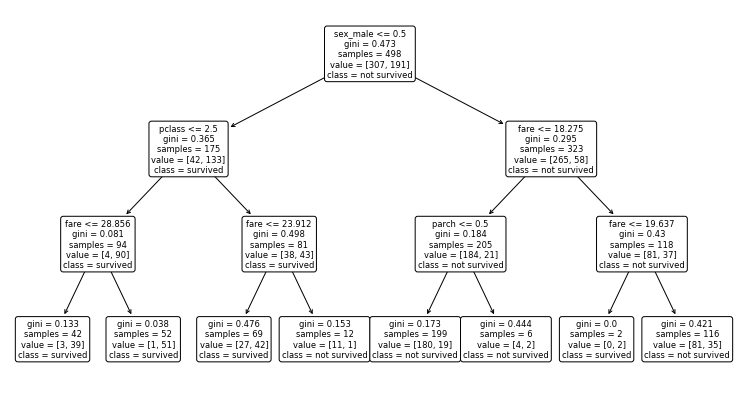

In [18]:
plt.figure(figsize=(13,7))
plot_tree(clf, feature_names=x_train.columns, class_names=['not survived', 'survived'], rounded = True)

In [19]:
# 3. Evaluate your in-sample results using the model score, confusion matrix, and classification report

In [20]:
y_pred = clf.predict(x_train)

In [21]:
y_pred_proba = clf.predict_proba(x_train)

In [22]:
clf.score(x_train, y_train)

0.8232931726907631

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_pred)

array([[276,  31],
       [ 57, 134]])

In [24]:
y_train.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [25]:
labels = sorted(y_train.unique())

In [26]:
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,276,31
1,57,134


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       307
           1       0.81      0.70      0.75       191

    accuracy                           0.82       498
   macro avg       0.82      0.80      0.81       498
weighted avg       0.82      0.82      0.82       498



In [28]:
# 4. Conpute accuracy, true positive rate, false positive rate, true negative reate, false negative rate, precision
# recall, f1-score, support
clf.score(x_validate, y_validate)

0.7850467289719626

In [29]:
y_pred = clf.predict(x_validate)

In [30]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       132
           1       0.76      0.65      0.70        82

    accuracy                           0.79       214
   macro avg       0.78      0.76      0.77       214
weighted avg       0.78      0.79      0.78       214



In [31]:
# 5. Repeat with a diff. max_depth

In [32]:
clf = DecisionTreeClassifier(max_depth=4, random_state=123)

In [33]:
clf = clf.fit(x_train, y_train)

[Text(607.8214285714286, 978.48, 'sex_male <= 0.5\ngini = 0.473\nsamples = 498\nvalue = [307, 191]\nclass = not survived'),
 Text(318.85714285714283, 761.0400000000001, 'pclass <= 2.5\ngini = 0.365\nsamples = 175\nvalue = [42, 133]\nclass = survived'),
 Text(159.42857142857142, 543.6, 'fare <= 28.856\ngini = 0.081\nsamples = 94\nvalue = [4, 90]\nclass = survived'),
 Text(79.71428571428571, 326.1600000000001, 'fare <= 28.231\ngini = 0.133\nsamples = 42\nvalue = [3, 39]\nclass = survived'),
 Text(39.857142857142854, 108.72000000000003, 'gini = 0.093\nsamples = 41\nvalue = [2, 39]\nclass = survived'),
 Text(119.57142857142856, 108.72000000000003, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = not survived'),
 Text(239.1428571428571, 326.1600000000001, 'parch <= 1.5\ngini = 0.038\nsamples = 52\nvalue = [1, 51]\nclass = survived'),
 Text(199.28571428571428, 108.72000000000003, 'gini = 0.0\nsamples = 48\nvalue = [0, 48]\nclass = survived'),
 Text(279.0, 108.72000000000003, 'gini = 0.375\n

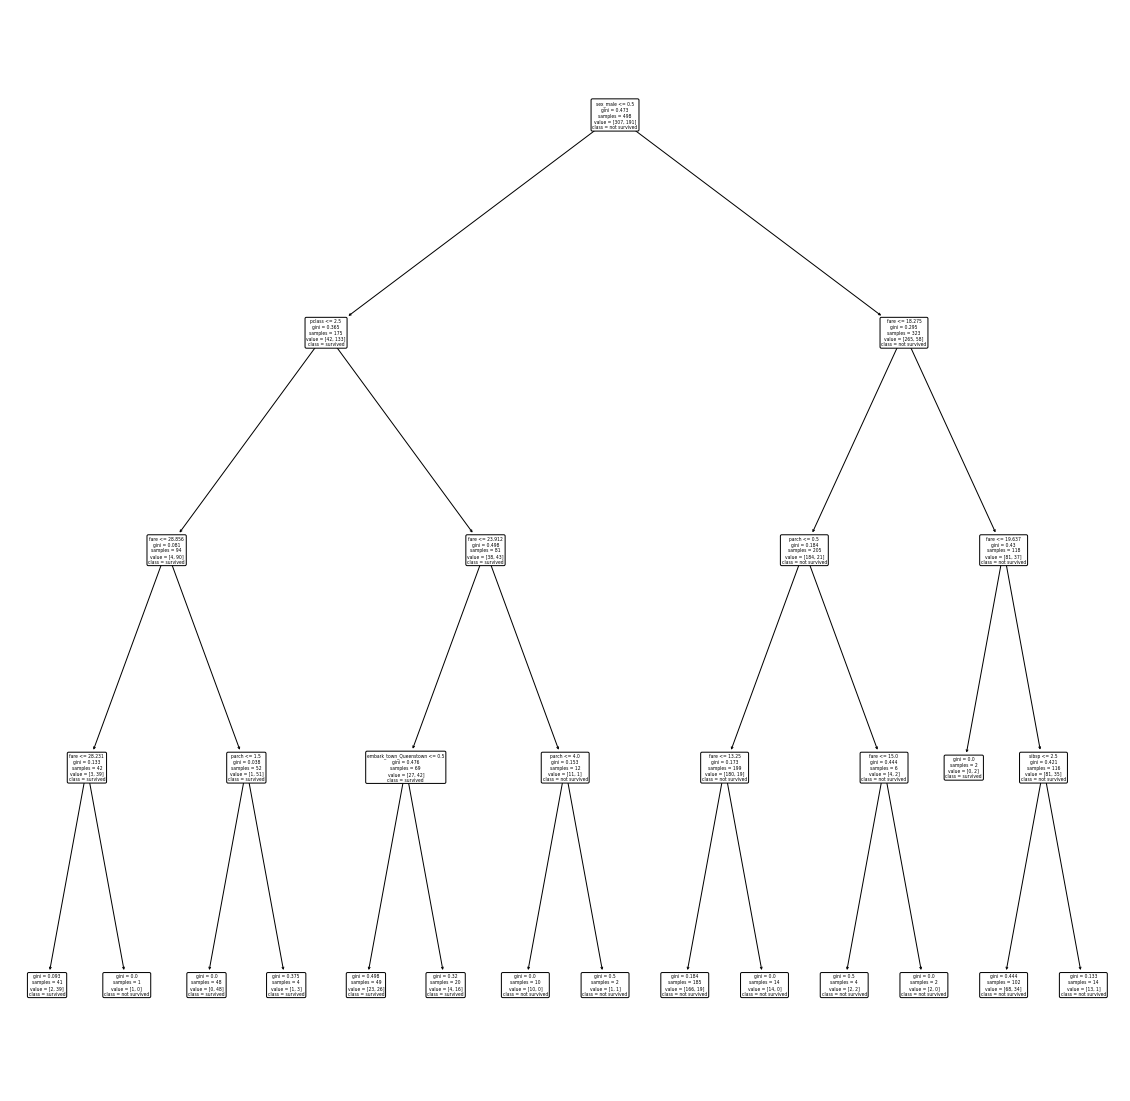

In [34]:
plt.figure(figsize=(20,20))
plot_tree(clf, feature_names=x_train.columns, class_names=['not survived', 'survived'], rounded = True)

In [35]:
y_pred = clf.predict(x_train)

In [36]:
y_pred_proba = clf.predict_proba(x_train)

In [37]:
clf.score(x_train, y_train)

0.8253012048192772

In [38]:
confusion_matrix(y_train, y_pred)

array([[277,  30],
       [ 57, 134]])

In [39]:
y_train.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [40]:
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,277,30
1,57,134


In [41]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       307
           1       0.82      0.70      0.75       191

    accuracy                           0.83       498
   macro avg       0.82      0.80      0.81       498
weighted avg       0.82      0.83      0.82       498



In [42]:
clf.score(x_validate, y_validate)

0.7850467289719626

In [43]:
y_pred = clf.predict(x_validate)

In [44]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       132
           1       0.76      0.65      0.70        82

    accuracy                           0.79       214
   macro avg       0.78      0.76      0.77       214
weighted avg       0.78      0.79      0.78       214



In [45]:
# 6. The larger max_depth performs better on the in sample (train) data
# 7. The larger max_depth performs better for the validate set as well. 

In [46]:
############################# Do these exercises using the telco dataset ########################################

In [46]:
telco = acquire.get_telco_data()

Using cached csv


In [47]:
telco = prepare.prep_telco(telco)

In [48]:
telco.head()

,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,internet_service_type_Fiber optic,internet_service_type_None,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,65.6,593.30,0,1,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,59.9,542.40,1,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
2,73.9,280.85,1,0,0,1,0,0,0,0,...,0,1,1,1,0,0,0,0,1,0
3,98.0,1237.85,1,1,0,1,0,0,0,0,...,1,1,1,1,0,0,0,0,1,0
4,83.9,267.40,0,1,0,1,0,0,0,0,...,0,1,1,1,0,0,0,0,0,1


In [49]:
# Locating the NaN values in df
is_nan = telco.isnull()
row_has_nan = is_nan.any(axis=1)
rows_with_nan = telco[row_has_nan]

In [52]:
telco.churn_Yes.value_counts()

0    5163
1    1869
Name: churn_Yes, dtype: int64

In [51]:
telco.isnull().values.any()

False

In [53]:
# The baseline is to not churn (target variable is churn)
telco['baseline'] = 0

In [54]:
sklearn.metrics.accuracy_score(telco.churn_Yes, telco.baseline)

0.7342150170648464

In [55]:
train, validate, test = train_validate_test_split(telco, 'churn_Yes', seed=123)

In [69]:
train.shape, validate.shape, test.shape

((3937, 30), (1688, 30), (1407, 30))

In [70]:
x_train = train.drop(columns='churn_Yes')
x_validate = validate.drop(columns='churn_Yes')
x_test = test.drop(columns='churn_Yes')

In [71]:
y_train = train.churn_Yes
y_validate = validate.churn_Yes
y_test = test.churn_Yes

In [72]:
clf = DecisionTreeClassifier(max_depth = 3, random_state=123)

In [73]:
clf = clf.fit(x_train, y_train)

[Text(502.20000000000005, 856.1700000000001, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.39\nsamples = 3937\nvalue = [2891, 1046]\nclass = no churn'),
 Text(251.10000000000002, 611.55, 'total_charges <= 237.275\ngini = 0.241\nsamples = 2215\nvalue = [1904, 311]\nclass = no churn'),
 Text(125.55000000000001, 366.93000000000006, 'internet_service_type_None <= 0.5\ngini = 0.453\nsamples = 539\nvalue = [352, 187]\nclass = no churn'),
 Text(62.775000000000006, 122.30999999999995, 'gini = 0.5\nsamples = 263\nvalue = [129, 134]\nclass = churn'),
 Text(188.32500000000002, 122.30999999999995, 'gini = 0.31\nsamples = 276\nvalue = [223, 53]\nclass = no churn'),
 Text(376.65000000000003, 366.93000000000006, 'contract_type_Two year <= 0.5\ngini = 0.137\nsamples = 1676\nvalue = [1552, 124]\nclass = no churn'),
 Text(313.875, 122.30999999999995, 'gini = 0.203\nsamples = 985\nvalue = [872, 113]\nclass = no churn'),
 Text(439.42500000000007, 122.30999999999995, 'gini = 0.031\nsamples = 691\nval

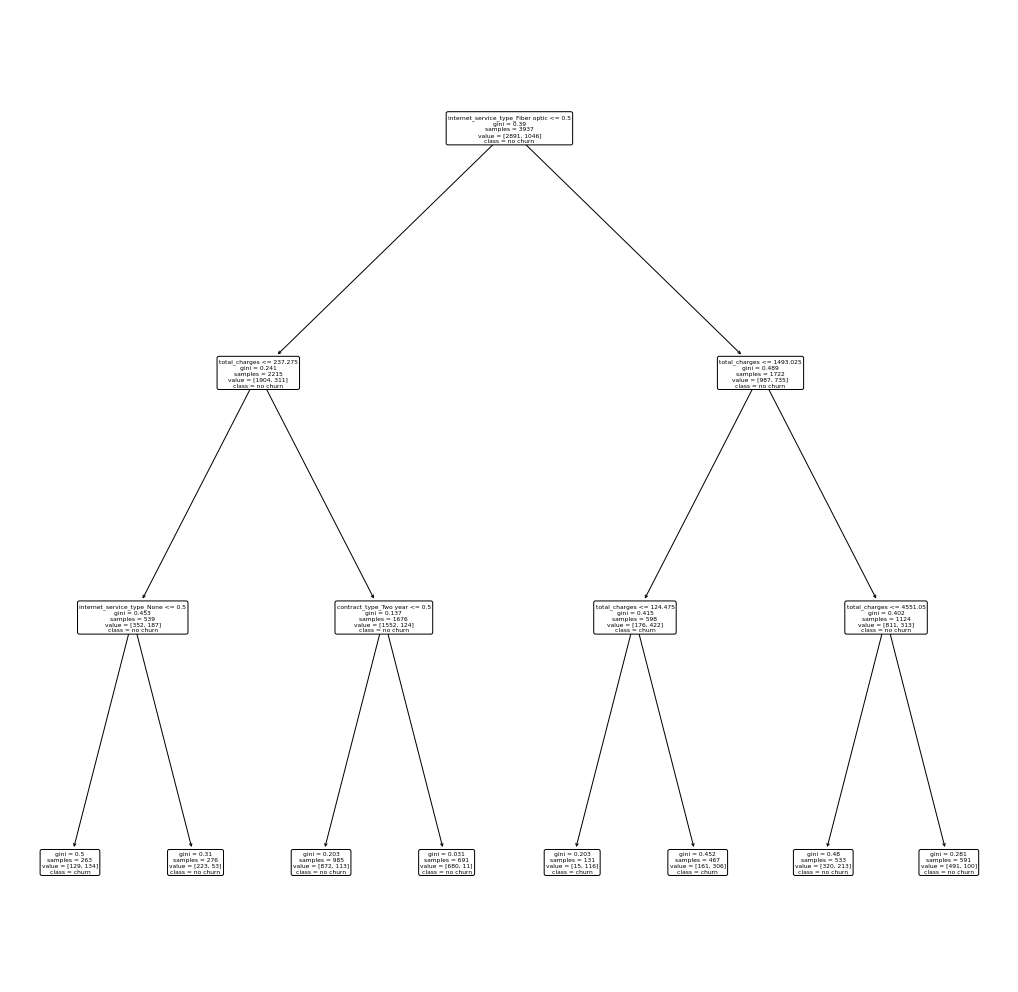

In [74]:
plt.figure(figsize=(18, 18))
plot_tree(clf, feature_names=x_train.columns, class_names=['no churn', 'churn'], rounded=True)

In [90]:
y_pred = clf.predict(x_train)

In [91]:
y_prep_proba = clf.predict_proba(x_train)

In [92]:
clf.score(x_train, y_train)

0.7980695961391923

In [93]:
confusion_matrix(y_train, y_pred)

array([[2586,  305],
       [ 490,  556]])

In [94]:
y_train.value_counts()

0    2891
1    1046
Name: churn_Yes, dtype: int64

In [95]:
labels = sorted(y_train.unique())
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,2586,305
1,490,556


In [96]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      2891
           1       0.65      0.53      0.58      1046

    accuracy                           0.80      3937
   macro avg       0.74      0.71      0.72      3937
weighted avg       0.79      0.80      0.79      3937



In [97]:
clf.score(x_validate, y_validate)

0.7742890995260664

In [98]:
y_pred = clf.predict(x_validate)

In [99]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1239
           1       0.59      0.50      0.54       449

    accuracy                           0.77      1688
   macro avg       0.71      0.69      0.70      1688
weighted avg       0.76      0.77      0.77      1688



In [104]:
clf = DecisionTreeClassifier(max_depth = 2, random_state=123)

In [105]:
clf = clf.fit(x_train, y_train)

[Text(362.7, 317.09999999999997, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.39\nsamples = 3937\nvalue = [2891, 1046]\nclass = no churn'),
 Text(181.35, 190.26, 'total_charges <= 237.275\ngini = 0.241\nsamples = 2215\nvalue = [1904, 311]\nclass = no churn'),
 Text(90.675, 63.420000000000016, 'gini = 0.453\nsamples = 539\nvalue = [352, 187]\nclass = no churn'),
 Text(272.025, 63.420000000000016, 'gini = 0.137\nsamples = 1676\nvalue = [1552, 124]\nclass = no churn'),
 Text(544.05, 190.26, 'total_charges <= 1493.025\ngini = 0.489\nsamples = 1722\nvalue = [987, 735]\nclass = no churn'),
 Text(453.375, 63.420000000000016, 'gini = 0.415\nsamples = 598\nvalue = [176, 422]\nclass = churn'),
 Text(634.725, 63.420000000000016, 'gini = 0.402\nsamples = 1124\nvalue = [811, 313]\nclass = no churn')]

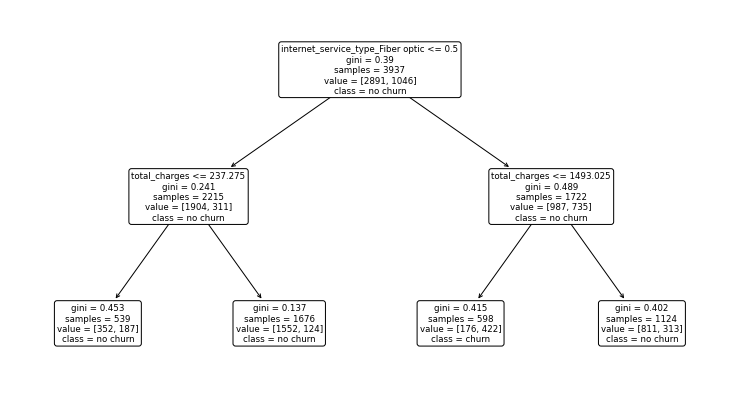

In [106]:
plt.figure(figsize=(13,7))
plot_tree(clf, feature_names = x_train.columns, class_names=['no churn', 'churn'], rounded = True)

In [107]:
y_pred = clf.predict(x_train)

In [108]:
clf.score(x_train, y_train)

0.7967995935991872

In [109]:
confusion_matrix(y_train, y_pred)

array([[2715,  176],
       [ 624,  422]])

In [110]:
y_train.value_counts()

0    2891
1    1046
Name: churn_Yes, dtype: int64

In [111]:
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,2715,176
1,624,422


In [112]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      2891
           1       0.71      0.40      0.51      1046

    accuracy                           0.80      3937
   macro avg       0.76      0.67      0.69      3937
weighted avg       0.78      0.80      0.78      3937



In [113]:
clf.score(x_validate, y_validate)

0.7725118483412322

In [116]:
y_pred = clf.predict(x_validate)
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1239
           1       0.61      0.39      0.48       449

    accuracy                           0.77      1688
   macro avg       0.71      0.65      0.67      1688
weighted avg       0.75      0.77      0.75      1688



In [117]:
# There is not as much difference as I would've expected between the max_depth of 2 or 3 for this data. The larger
# max_depth still provides better results, but not by as much as I would have guessed. 

In [118]:
################################################################################################################

In [119]:
# Random Forest Exercise

In [120]:
# 1. Fit the Random Forest classifier to your training sample and tansform, setting random_state accordingly and 
# setting min_samples_leaf = 1 and max_depth = 10

In [121]:
from sklearn.ensemble import RandomForestClassifier

In [128]:
titanic = acquire.get_titanic_data()

Using cached csv


In [129]:
titanic = prepare.prep_titanic(titanic)

In [130]:
train, validate, test = train_validate_test_split(titanic, 'survived', seed=123)

In [131]:
train.shape, validate.shape, test.shape

((498, 9), (214, 9), (179, 9))

In [132]:
x_train = train.drop(columns='survived')
y_train = train.survived

In [133]:
x_validate = validate.drop(columns='survived')
y_validate = validate.survived
x_test = test.drop(columns='survived')
y_test = test.survived

In [136]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf=1, max_depth=10,
                           n_estimators=100, random_state=123)

In [137]:
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, random_state=123)

In [138]:
print(rf.feature_importances_)

[0.10002143 0.06879504 0.05292745 0.3838233  0.02319394 0.32803056
 0.01522288 0.02798539]


In [139]:
y_pred = rf.predict(x_train)

In [140]:
y_pred_proba = rf.predict_proba(x_train)

In [141]:
rf.score(x_train, y_train)

0.9437751004016064

In [142]:
print(confusion_matrix(y_train, y_pred))

[[301   6]
 [ 22 169]]


In [143]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       307
           1       0.97      0.88      0.92       191

    accuracy                           0.94       498
   macro avg       0.95      0.93      0.94       498
weighted avg       0.94      0.94      0.94       498



In [144]:
rf.score(x_validate, y_validate)

0.7850467289719626